n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  0.000000E+00 |  0.0123437005 |  0.3388474290 |  0.0262129732
     2 |      200 |  0.000000E+00 |  0.000000E+00 |  0.1253719250 |  0.0002442510
     3 |      300 |  0.000000E+00 |  0.000000E+00 |  0.0740715922 |  0.0002442510
     4 |      400 |  0.000000E+00 |  0.000000E+00 |  0.0510499167 |  0.0002442510
     5 |      500 |  0.000000E+00 |  0.000000E+00 |  0.0309985461 |  0.0002442510
     6 |      600 |  0.000000E+00 |  0.000000E+00 |  0.0181254472 |  0.0002442510
     7 |      700 |  0.000000E+00 |  0.000000E+00 |  0.0118437162 |  0.0002442510
     8 |      800 |  0.000000E+00 |  0.000000E+00 |  0.0088090157 |  0.0002442510
     9 |      900 |  0.000000E+00 |  0.000000E+00 |  0.0069481763 |  0.0001961851
    10 |     1000 |  0.000000E+00 |  0.000000E+00 |  0.0048961490 |  0.0000704347
    11 |     1100 |  0.000000E+00 |  0.000000E+00 |  0.0038140734 |  0.0000704347
    12 |     120

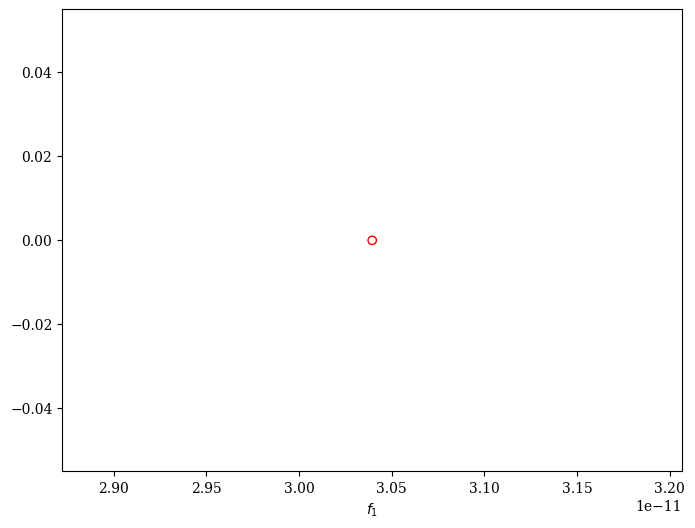

In [3]:
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import numpy as np
from pymoo.algorithms.soo.nonconvex.ga import GA

G = 2216.1  # %整车半载重量（Kg）
G_f = 1108.1  # %半载前轴荷（Kg）
G_r = G - G_f  # %半载后轴荷（Kg）
wheel_track_f = 1580.3  # %轮距（mm）
wheel_track_r = 1580.3  # %轮距（mm）
vehicle_height = 1800  # %车辆高度（mm）
area_aero = (wheel_track_f + wheel_track_r) / 2 * vehicle_height * 1e-6  # %迎风面积估算，m^2
wheel_track_f = 1580.3  # %轮距（mm）
wheel_track_r = 1580.3  # %轮距（mm）
vehicle_height = 1800  # %车辆高度（mm）
nr_f = 30.000  # %轮胎拖距，设计参数，mm
nr_r = 30.000  # %轮胎拖距，设计参数，mm
toe_f = 0.0  # %设计状态下前束角，deg
toe_r = 0.12  # %设计状态下前束角，deg
total_roll_grad_t = 4.500  # %选取一个侧倾梯度，deg/g

# %轮胎导入的侧偏柔度/侧倾刚度
tire_corner_stiff_f = 2000  # %前轮胎在设计状态下的侧偏刚度，N/deg
tire_corner_stiff_r = 2000  # %后轮胎在设计状态下的侧偏刚度，N/deg
tire_incline_stiff_f = 134  # %前轮胎在设计状态下的侧倾刚度，N/deg
tire_incline_stiff_r = 134  # %后轮胎在设计状态下的侧倾刚度，N/deg
Uc = 60 / 3.6  # %输入车速
dirve_f = 0.5  # %前轮驱动力占比

# % 四轮定位参数
nk = 39.000  # %主销拖距，输入参数，mm
nr_f = 30.000  # %轮胎拖距，设计参数，mm
nr_r = 30.000  # %轮胎拖距，设计参数，mm
toe_f = 0.0  # %设计状态下前束角，deg
toe_r = 0.12  # %设计状态下前束角，deg

# pymoo 求解
# 1、定义问题
# 2、选择算法
# 3、设置终止条件
# 4、求解优化问题

class MinimizeMassProblem(Problem):
    def __init__(self):
        # n_var 变量个数 n_obj 目标个数，n_ieq_constr 不平等约束个数，n_eq_constr 平等约束个数
        # xl 长度为n_var，表示变量的下界，xu 长度为n_var，表示变量的上界
        super().__init__(n_var=12,
                         n_obj=1,
                         n_ieq_constr=4,
                         xl=np.array([
                             1.0E-3, 0.5E-3, -0.14E-3, 0.01E-3, -0.15e-3,
                             -0.15e-3, -10e-2, 0e-2, -0.90, -0.85, -0.25e-3,
                             -0.25e-3
                         ]),
                         xu=np.array([
                             2.0E-3, 1.0E-3, -0.01E-3, 0.07E-3, 0.15e-3,
                             0.15e-3, -2e-2, 6e-2, -0.65, -0.55, -0.1e-3,
                             -0.1e-3
                         ]))

    def _evaluate(self, x, out, *args, **kwargs):
        #悬架KC参数
        align_comp_f = x[:, 0]
        align_comp_r = x[:, 1]
        fy_steer_f = x[:, 2]
        fy_steer_r = x[:, 3]
        fx_steer_f = x[:, 4]
        fx_steer_r = x[:, 5]
        roll_steer_f = x[:, 6]
        roll_steer_r = x[:, 7]
        roll_camber_f = x[:, 8]
        roll_camber_r = x[:, 9]
        fy_camber_f = x[:, 10]
        fy_camber_r = x[:, 11]
        
        # %侧向力转向贡献
        fy_steer_nr_f = fy_steer_f + align_comp_f * (
            (-nr_f) / 1000)  # %考虑轮胎拖距的侧向力转向系数，deg / N
        fy_steer_nr_r = fy_steer_r + align_comp_r * ((-nr_r) / 1000)  #
        fy_toe_comp_f = fy_steer_nr_f * G_f * 9.807  # %前轴KC特性侧偏柔度，deg / g
        fy_toe_comp_r = fy_steer_nr_r * G_r * 9.807  # %后轴KC特性侧偏柔度，deg / g

        # %侧倾转向贡献
        roll_str_comp_f = roll_steer_f * total_roll_grad_t  # %前悬架侧倾转向柔度
        roll_str_comp_r = roll_steer_r * total_roll_grad_t  # %后悬架侧倾转向柔度

        # %轮胎导入的贡献
        tire_comp_f = -9.807 * G_f / (tire_corner_stiff_f * 2)  # %前轮胎导入的侧偏柔度
        tire_comp_r = -9.807 * G_f / (tire_corner_stiff_r * 2)  # %后轮胎导入的侧偏柔度

        # %驱动力导入的侧偏柔度，车辆均速行驶，空气阻力系数为0.3
        Fw = 0.5 * 0.3 * area_aero * 1.206 * Uc**2  # %空气阻力，N
        fx_steer_angle_f = fx_steer_f * Fw * dirve_f  # %前轮驱动力导入的前轮前束角，deg
        fx_steer_angle_r = fx_steer_r * Fw * (1 - dirve_f
                                              )  # %后轮驱动力导入的后轮前束角，deg

        # %侧向外倾的贡献
        roll_camber_comp_f = tire_incline_stiff_f * roll_camber_f * total_roll_grad_t / tire_corner_stiff_f  # %前轮侧倾外倾的前轮前束角，deg
        roll_camber_comp_r = tire_incline_stiff_r * roll_camber_r * total_roll_grad_t / tire_corner_stiff_r  # %后轮侧倾外倾的前轮前束角，deg

        # %侧向力外倾的贡献
        fy_camber_comp_f = tire_incline_stiff_f * fy_camber_f * G_f / 2 * 9.8 / tire_corner_stiff_f  # %前轮侧向力外倾的前轮前束角，deg
        fy_camber_comp_r = tire_incline_stiff_r * fy_camber_r * G_r / 2 * 9.8 / tire_corner_stiff_r  # %后轮侧向力外倾的前轮前束角，deg

        # %前悬架侧偏柔度，deg / g        （-4  ~-5.5）
        comp_f = fy_toe_comp_f + roll_str_comp_f + tire_comp_f + fx_steer_angle_f + toe_f + roll_camber_comp_f + fy_camber_comp_f

        # %后悬架侧偏柔度，deg / g       （-2~-3）
        comp_r = fy_toe_comp_r + roll_str_comp_r + tire_comp_r + fx_steer_angle_r + toe_r + roll_camber_comp_r + fy_camber_comp_r

        # 目标函数
        out["F"] = np.abs(-(comp_f - comp_r) - 2.0)

        # 约束条件
        ieq_constr_1 = -5.5 - comp_f
        ieq_constr_2 = comp_f - (-4)
        ieq_constr_3 = -3 - comp_r
        ieq_constr_4 = comp_r - (-2)
        out["G"] = [ieq_constr_1, ieq_constr_2, ieq_constr_3, ieq_constr_4]


problem = MinimizeMassProblem()
algorithm = GA(pop_size=100, eliminate_duplicates=True)
res = minimize(problem, algorithm, seed=2, verbose=True)

# 真值参考 x(0.08983,-0.7126),x(-0.08983,0.7126) min y(-1.0316285)
print('best_x is ', res.X, 'best_y is', res.F + 2.0)
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [4]:
?GA